In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.loading import *
from src.utils import *
from src.saving import *

In [2]:
# Computes the difference in time steps of PC coordinates
# Re-indexes time steps to match
#
def _compute_delta_pc(pcs, method, n=1, dt=3):
    if method=='centered':
        time_step = 2*n*dt
        pivot = 'mid'
        delta_pc_values = (
            pcs.isel(time=slice(2*n, None)).data -
            pcs.isel(time=slice(None, -2*n)).data
        )
        time_slice = slice(n, -(n))
    elif method=='forward':
        time_step = n*dt
        pivot = 'tail'
        delta_pc_values = (
            pcs.isel(time=slice(n, None)).data -
            pcs.isel(time=slice(None, -n)).data
        )
        time_slice = slice(None, -(n))
    elif method=='backward':
        time_step = n*dt
        pivot = 'tip'
        delta_pc_values = (
            pcs.isel(time=slice(n, None)).data -
            pcs.isel(time=slice(None, -n)).data
        )
        time_slice = slice(n, None)
    
    return pcs.isel(time=time_slice).copy(data=delta_pc_values/time_step), pivot

# gSAM

In [3]:
# Parameters for analysis and plotting
obs_cutoff = 5
arrow_space=1
scale = 1

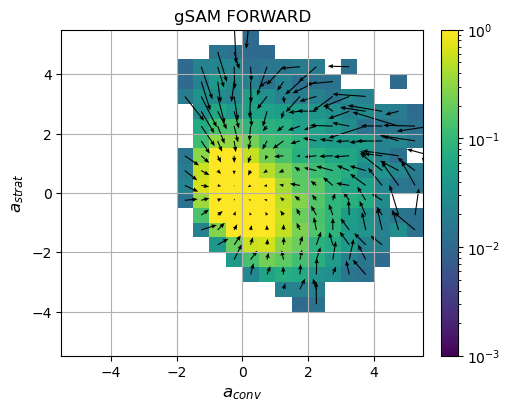

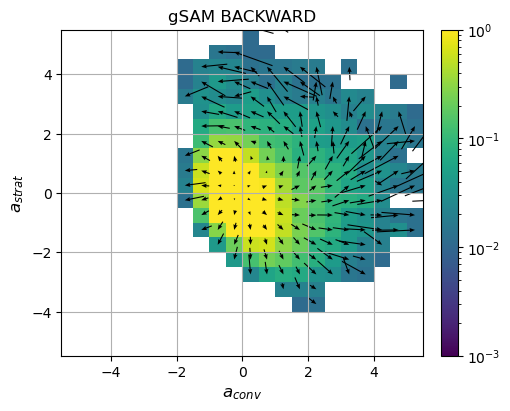

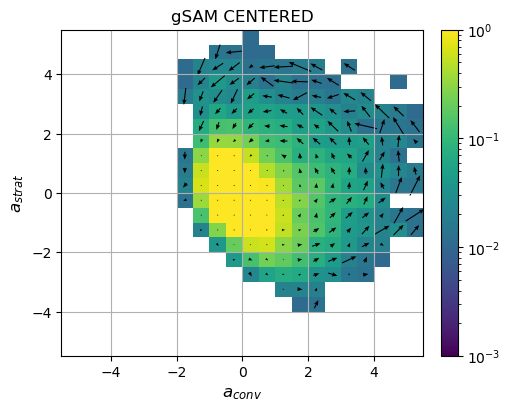

In [8]:
for method in ['forward', 'backward', 'centered']:
    # Load PCs and normalize them by std dev
    #
    pcs = load_gsam_eofs_pcs().scores()
    pcs = pcs/pcs.std(('lat', 'lon', 'time'))
    # Compute deltas of PCs by chosen method. Only keep corresponding times. 
    # Time indexing of delta_pc handled by _compute_delta_pc
    #
    delta_pc, pivot = _compute_delta_pc(pcs, method, n=1, dt=3)
    pcs = pcs.sel(time=delta_pc.time)
    # Set bins for PCs and make plotting mesh
    #
    pc_bins = np.arange(-10, 10, 0.5)
    xmesh, ymesh = np.meshgrid(array_midpoints(pc_bins), array_midpoints(pc_bins))
    # Compute the counts and means of PC and delta PCs for bins
    #
    counts = binned_statistic_2d(
        pcs.sel(mode=2).data.ravel(), # y-coordinate data first
        pcs.sel(mode=1).data.ravel(), # x-coordinate data first
        None, 
        statistic='count',
        bins = [pc_bins, pc_bins]
    ).statistic

    mean_delta_x = binned_statistic_2d(
        pcs.sel(mode=2).data.ravel(), # y-coordinate data first
        pcs.sel(mode=1).data.ravel(), # x-coordinate data first
        delta_pc.sel(mode=1).data.ravel(),
        statistic=lambda x: np.nanmean(x) if x.size>obs_cutoff else np.nan, 
        bins = [pc_bins, pc_bins]
    ).statistic

    mean_delta_y = binned_statistic_2d(
        pcs.sel(mode=2).data.ravel(), # y-coordinate data first
        pcs.sel(mode=1).data.ravel(), # x-coordinate data first
        delta_pc.sel(mode=2).data.ravel(),
        statistic=lambda x: np.nanmean(x) if x.size>obs_cutoff else np.nan, 
        bins = [pc_bins, pc_bins]
    ).statistic

    # Plot the histogram in shading and add quiver
    #
    fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)
    samp = (slice(None, None, arrow_space), slice(None, None, arrow_space))  # keeps arrows from being too dense
    c = ax.pcolormesh(
        xmesh,
        ymesh,
        np.ma.masked_array(100*counts/counts.sum(), mask=counts<obs_cutoff),
        norm=colors.LogNorm(vmin=1e-3, vmax=1e0),
        cmap=plt.cm.viridis.copy()
    )

    ax.quiver(
        xmesh[samp],
        ymesh[samp],
        mean_delta_x[samp],
        mean_delta_y[samp],
        angles='xy',
        pivot=pivot,
        scale=scale,
        scale_units='xy',
        width=0.003, headwidth=4, facecolor='black'
    )

    ax.grid()
    ax.set_xlim(-5.5, 5.5)
    ax.set_ylim(-5.5, 5.5)
    ax.set_xlabel(r'$a_{conv}$', fontsize=12)
    ax.set_ylabel(r'$a_{strat}$', fontsize=12)
    ax.set_title(f'gSAM {method.upper()}')
    fig.colorbar(c)
    save_figure(fig, f'gSAM_Large-Scale_Evolution_{method}.pdf')

# ERA5 

In [5]:
# Parameters for analysis and plotting
obs_cutoff = 5
arrow_space=1
scale = 1

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_49251/2253978974.py:63: RuntimeWarning: invalid value encountered in divide
  mean_delta_x = np.stack(quiver_plot_data['sum_delta_pc1']).sum(axis=0)/counts
/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_49251/2253978974.py:64: RuntimeWarning: invalid value encountered in divide
  mean_delta_y = np.stack(quiver_plot_data['sum_delta_pc2']).sum(axis=0)/counts
/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_49251/2253978974.py:63: RuntimeWarning: invalid value encountered in divide
  mean_delta_x = np.stack(quiver_plot_data['sum_delta_pc1']).sum(axis=0)/counts
/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_49251/2253978974.py:64: RuntimeWarning: invalid value encountered in divide
  mean_delta_y = np.stack(quiver_plot_data['sum_delta_pc2']).sum(axis=0)/counts
/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_49251/2253978974.py:63: RuntimeWarning: invalid value encountered in divide
  mea

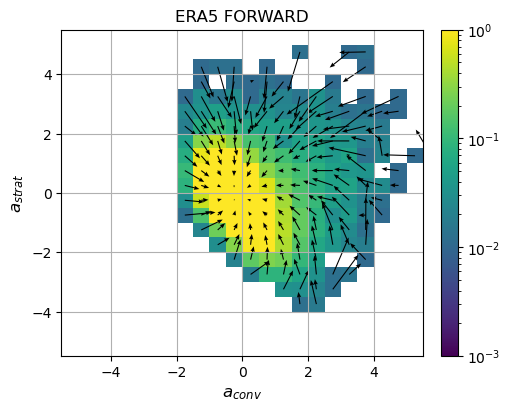

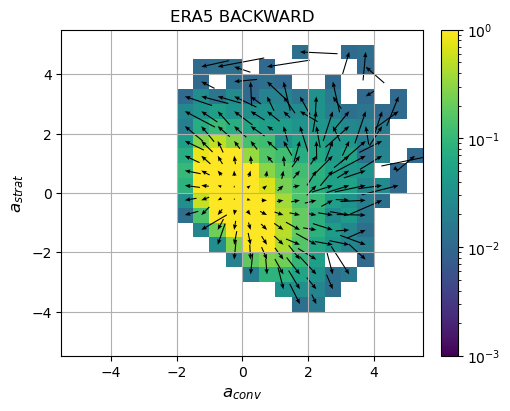

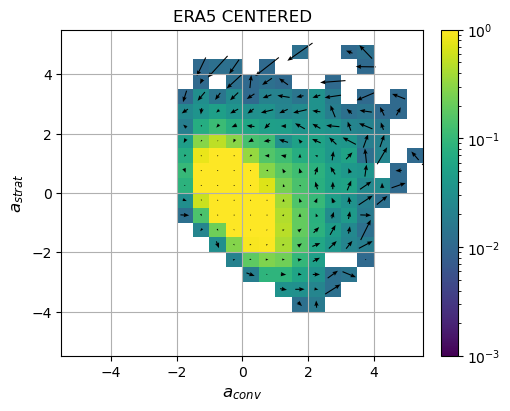

In [9]:
for method in ['forward', 'backward', 'centered']:
    # Load PCs and normalize them by std dev
    #
    pcs = load_era5_eofs_pcs().scores()
    pcs = pcs/pcs.std(('latitude', 'longitude', 'time'))
    # Only get 2020 data. Remove this for a longer composite
    #
    pcs = pcs.isel(time=pcs.time.dt.year==2020)
    # Set bins for PCs and make plotting mesh
    #
    pc_bins = np.arange(-10, 10, 0.5)
    xmesh, ymesh = np.meshgrid(array_midpoints(pc_bins), array_midpoints(pc_bins))
    # Since the PCs come from different years, we need to compute each year seperately.
    # Counts and sum of deltas will be stored in a dict, mean will be computed after
    #
    pcs_grouped = pcs.groupby(pcs.time.dt.year)
    quiver_plot_data = {
        'year': [],
        'counts': [],
        'sum_delta_pc1': [],
        'sum_delta_pc2': []
    }
    for year, ypcs in pcs_grouped:
        delta_pcs, pivot = _compute_delta_pc(ypcs, method, n=1, dt=3)
        ypcs = ypcs.sel(time=delta_pcs.time)
        quiver_plot_data['year'].append(year)

        # Counts
        #
        quiver_plot_data['counts'].append(
            binned_statistic_2d(
                ypcs.sel(mode=2).data.ravel(), # y-coordinate data first
                ypcs.sel(mode=1).data.ravel(), # x-coordinate data first
                None, 
                statistic='count',
                bins = [pc_bins, pc_bins]
            ).statistic
        )
        # Sum of delta pcs
        #
        quiver_plot_data['sum_delta_pc1'].append(
            binned_statistic_2d(
                ypcs.sel(mode=2).data.ravel(), # y-coordinate data first
                ypcs.sel(mode=1).data.ravel(), # x-coordinate data first
                delta_pcs.sel(mode=1).data.ravel(), 
                statistic=np.nansum,
                bins = [pc_bins, pc_bins]
            ).statistic
        )
        quiver_plot_data['sum_delta_pc2'].append(
            binned_statistic_2d(
                ypcs.sel(mode=2).data.ravel(), # y-coordinate data first
                ypcs.sel(mode=1).data.ravel(), # x-coordinate data first
                delta_pcs.sel(mode=2).data.ravel(), 
                statistic=np.nansum,
                bins = [pc_bins, pc_bins]
            ).statistic
        )

    # Combine year data into single histogram and quiver plot
    #
    counts = np.stack(quiver_plot_data['counts']).sum(axis=0)
    mean_delta_x = np.stack(quiver_plot_data['sum_delta_pc1']).sum(axis=0)/counts
    mean_delta_y = np.stack(quiver_plot_data['sum_delta_pc2']).sum(axis=0)/counts

    # Plot the histogram in shading and add quiver
    #
    fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)
    samp = (slice(None, None, arrow_space), slice(None, None, arrow_space))  # keeps arrows from being too dense
    mask = counts<obs_cutoff  # what pixels to not show due to small data samle
    c = ax.pcolormesh(
        xmesh,
        ymesh,
        np.ma.masked_array(100*counts/counts.sum(), mask=mask),
        norm=colors.LogNorm(vmin=1e-3, vmax=1e0),
        cmap=plt.cm.viridis.copy()
    )
    ax.quiver(
        xmesh[samp],
        ymesh[samp],
        np.ma.masked_array(mean_delta_x[samp], mask=mask),
        np.ma.masked_array(mean_delta_y[samp], mask=mask),
        angles='xy',
        pivot=pivot,
        scale=10,
        width=0.003, headwidth=4, facecolor='black'
    )

    ax.grid()
    ax.set_xlim(-5.5, 5.5)
    ax.set_ylim(-5.5, 5.5)
    ax.set_xlabel(r'$a_{conv}$', fontsize=12)
    ax.set_ylabel(r'$a_{strat}$', fontsize=12)
    ax.set_title(f'ERA5 {method.upper()}')
    fig.colorbar(c)
    save_figure(fig, f'ERA5_Large-Scale_Evolution_{method}.pdf')